# Mini-Lab: Logistic Regression and SVMs
# New York City Fire Department Data: Predicting High-Alarm vs. Low-Alarm Fires

## Team: Aditya Garapati, Chase Henderson, Brian Waite, Carl Walenciak
## Date: 10/6/2019


In [4]:
#!pip install category_encoders

In [5]:
#Imports Section
import category_encoders as ce
import pandas as pd
#from google.colab import drive #Not needed if file uploaded directly
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#Setup to read from Google Drive
#drive.mount('/content/drive')

#Read the final_df file from colab local storage. 
#Must be in the '/' directory location and must be uploaded every time the runtime
#is refreshed. 
final_df = pd.read_pickle('final_df.pkl')


# Business Understanding: Problem Statement

## General Description:

This is a continuation of the analysis of the Fire Department of New York City (FDNY) data describing fire incidents in support of the New York Fire Incident Reporting System (NYFIRS). Prior to and during our initial data preparation, we identified a number of analytic questions that could be of interest to fire resource planners. 

New York City uses a series of alarm codes to identify the severity of a fire and the associated response. These alarm codes are described at the following web locations: 

http://www.fdnewyork.com/aa.asp

https://en.wikipedia.org/wiki/New_York_City_Fire_Department#Radio_and_bell_code_signals


## Problem Statement: 

Build a classification model that can **predict whether a fire constitutes a severe, high level incident, or a less-severe fire** based on parameters contained in the available data set. 

By building this classification model, we seek not only to identify the level of incidents based on parameters, but also to identify factors that contribute to an incident being classified as a high-level / low-level incident in order to aid planners in their future decision making process. 

## Approach: 

At this stage, we will seek to build this model using both logistic regression and support vector machine approaches. With each we will attempt to interpret the model parameters to understand the contributors as discussed in the problem statement. 

We will optimize these models by tuning parameters and using feature reduction techniques. At this point, we will not execute cross validation within the data and will be using a simple 80/20 train/test split as directed. 

# Data Understanding: 

## Data Description: 

A robust description of the data has been previously provided along with an associated Exploratory Data Analysis. That information is available here for reference: https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Playing_With_Fire.ipynb

## Data Cleaning: 

To optimize this analysis, we need to do some additional transformation of the data and some leftover housekeeping from our EDA. This will include: 

* Conversion of the presence of the Automatic Extinguisher System to either "not present = 0" or "present = 1". 

* Conversion of the presence of a fire dector to either "not present = 0" or "present = 1". 

* Conversion of the presence of a standpipe system to "not present = 0" or "present = 1". 

* Filling of missing `total_incident_duration` values with the mean value. 

* Correction of two incorrect zip code values. 

* Dropping of categorical fields that are freely input by the user and are unusable for analysis or are not consistently used in a meaningful sense for this problem. 

In [6]:
#AES presence update
final_df.loc[final_df['aes_presence_desc'] == '1 - Present', 'aes_presence_desc'] = 1
final_df.loc[final_df['aes_presence_desc'] != 1, 'aes_presence_desc'] = 0

#Smoke Detector presence update
final_df.loc[final_df['detector_presence_desc'] == '1 - Present', 'detector_presence_desc'] = 1
final_df.loc[final_df['detector_presence_desc'] != 1, 'detector_presence_desc'] = 0

#Standpipe presence update
final_df.loc[final_df['standpipe_sys_present_flag'] == '1', 'standpipe_sys_present_flag'] = 1
final_df.loc[final_df['standpipe_sys_present_flag'] != 1, 'standpipe_sys_present_flag'] = 0

#Total Incident Duration imputation
final_df['total_incident_duration'].fillna((final_df['total_incident_duration'].mean()), inplace=True)

#Replacement of missing zip codes
#Identified values using google maps and intersection information
final_df.at[18695, 'zip_code'] = '11103'
final_df.at[18760, 'zip_code'] = '11357'

#Drop the categorical columns determined to be unusable
final_df = final_df.drop(columns = ['fire_spread_desc','floor','story_fire_origin_count'])

#Drop the remaining 17 values that are missing the highest level alarm description
final_df.dropna(inplace = True)

## Construction of a Target Variable: 

Because the target variable is not currently in the data set, we must construct it with the existing available data set. 

Here we will take the existing feature, `highest_level_desc` that defines the level of alarm raised for each incident in the data set and convert it to a binary value. The values contained in the data set are: 

In [7]:
final_df.highest_level_desc.unique()

array(['11 - First Alarm', '75 - All Hands Working',
       '1 - More than initial alarm, less than Signal 7-5',
       '7 - Signal 7-5', '2 - 2nd alarm', '0 - Initial alarm',
       '22 - Second Alarm', '5 - 5th alarm', '4 - 4th alarm',
       '3 - 3rd alarm', '55 - Fifth Alarm', '33 - Third Alarm',
       '44 - Fourth Alarm'], dtype=object)

As you might expect, the majority of the events occuring throughout the city are low-level fires.

In [8]:
grouped = final_df.groupby(['highest_level_desc'])
grouped.count().im_incident_key

highest_level_desc
0 - Initial alarm                                       19
1 - More than initial alarm, less than Signal 7-5    12963
11 - First Alarm                                     11873
2 - 2nd alarm                                           53
22 - Second Alarm                                       47
3 - 3rd alarm                                           15
33 - Third Alarm                                        11
4 - 4th alarm                                            4
44 - Fourth Alarm                                        5
5 - 5th alarm                                            5
55 - Fifth Alarm                                         5
7 - Signal 7-5                                         701
75 - All Hands Working                                 621
Name: im_incident_key, dtype: int64

This means we have the potential for the data of "in class" vs. "out of class" to be highly imbalanced. We'll address this later in our analysis. For our analysis, we determined based on the definitions of the alarms in the references provided and on our initial EDA, that a severe fire is level 2 including Signal 7 / Signal 75, which are not truly 2 alarm or higher, but help to balance the in class data set. 

In [9]:
#Split the alarm code off the front of the description
new = final_df["highest_level_desc"].str.split(" ", n = 1, expand = True) 
#Convert to integer
new[0] = new[0].astype('int32')
#Map the classifications according to alarm code
desc = {2: 1,22: 1, 3:1,33:1,4:1,44:1,5:1,55:1,0:0,1:0,11:0,7:1,75:1,} 
final_df['FireLevel'] = [desc[item] for item in new[0]] 

In [10]:
#Number of in class records
final_df.FireLevel.sum()

1467

In [11]:
#Total number of records
final_df.FireLevel.shape[0]

26322

Our target variable is now contained in the data frame as `FireLevel`. As we can see, there are 1,467 in class values out of the total 26,322 records. Approximately 5.6 percent. We will monitor and adjust for this imbalance throughout our analysis. 

## Encoding of Categorical Predictors

In order to ensure the categorical values are providing balanced contributions to the model, we leverage one-hot encoding. This significantly increases the number of features. 

In [12]:
#Encode borough description
label = ce.OneHotEncoder(use_cat_names=True)
borough_label = label.fit_transform(final_df[['borough_desc']])

#Encode incident type
label = ce.OneHotEncoder(use_cat_names=True)
incident_type_label = label.fit_transform(final_df[['incident_type_desc']])

#Encode actiontaken 1 label -- the primary action taken by units onscene
label = ce.OneHotEncoder(use_cat_names=True)
action_taken_1_label = label.fit_transform(final_df[['action_taken1_desc']])

## Drop Columns Not to be Used in Analysis

A number of the columns in the dataframe are now duplicative of the encoded columns or are redundant / not useful. Things like zip_code, street_highway, and nearest_intersection are already captured in lat/long that we'll retain. Some of the date time information is already captured in the total_incident_duration feature. 

In [13]:
#drop the unnecessary columns
model_df = final_df.drop(columns = ['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc', 'borough_desc','fire_box', 'highest_level_desc', 'im_incident_key', 'incident_date_time', 'incident_type_desc', 'last_unit_cleared_date_time', 'property_use_desc', 'street_highway', 'zip_code', 'nearest_intersection','incident_code', 'incident_desc', 'DATE'])

In [14]:
#concatenate the encoded columns
model_df = pd.concat([model_df,incident_type_label, action_taken_1_label, borough_label], axis = 1)

In [15]:
#Move the target value to the end of the dataframe and rename as target
model_df['target'] = model_df['FireLevel']
model_df = model_df.drop(columns = 'FireLevel')

# Modelling: 

In order to prepare for the analysis, we will use a simple 80/20 Train-Test split with no cross validation. The data is randomly selected for inclusion in either split, with a set seed to enable replication of results. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(model_df.iloc[:,0:99], model_df.iloc[:,99], test_size=0.20, random_state=42)

### Checking the impact of our unbalanced data set

Checking our concern about having a largely unbalanced set of records for in / out of class examples, we ran a dummy classifier with a 'most frequent' strategy to see how it would perform. As expected, the dummy classifier still obtained 94.5% accuracy indicating that we must do something to address this large imbalance. We also recognize that accuracy may not be the best score going forward. 

In [17]:
from sklearn.dummy import DummyClassifier
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Accuracy test score: ', mt.accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Accuracy test score:  0.9451092117758785


### Upsampling to obtain balanced records

To address the large imbalance in the data set, we successfully implemented code to up-sample the "in-class" records in the data set to be equally present in the data set with "out of class" records. 

In [18]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.target==0]
fraud = X[X.target==1]

# upsample minority
fraud_upsampled = resample(fraud, replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.target.value_counts()

1    19879
0    19879
Name: target, dtype: int64

This same process can be used by using the class_weight = 'balanced' flag when creating the LogisticRegression object, but we wanted to execute the up-sampling to understand the process for doing so. 

### Logistic Regression: Baseline

We initially fit a baseline logistic regression model on the scaled features using default parameters adjusting for the balanced class values and with an 'l2' penalty and C = 0.05 due to the scaled features. Lbfgs is set as the solver as this is emerging as the default and with 800 iterations to ensure convergance. 

In [19]:
#Default logistic regression model


# Scale training set attributes using code provided in class
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set

# train the model just as before
lr_clf = LogisticRegression(solver = 'lbfgs', max_iter = 800, penalty='l2', C=0.05, class_weight='balanced')
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions


# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_test,y_hat)) 
print("confusion matrix\n",mt.confusion_matrix(y_test,y_hat))

accuracy 0.9715099715099715
confusion matrix
 [[4843  133]
 [  17  272]]


Off the bat, the 97% accuracy metric seems too good to be true. It may be that accuracy alone is not the best metric. Strongly correlated values in the data set such as the number of responding units (`units_onscene`) and the total length of the incident (`total_incident_length`) might correlate strongly with the outcome. Exploring this further offers some interesting insights. 

Expanding our metrics, we can see that the precision of our model is significantly lower than the accuracy and recall parameters. This is an indication that our model is producing a high false positive rate. That said, the ROC curve below looks extremely strong. 

In [20]:
#Precision and recall
print("precision", mt.precision_score(y_test, y_hat))
print("recall", mt.recall_score(y_test, y_hat))

precision 0.671604938271605
recall 0.9411764705882353


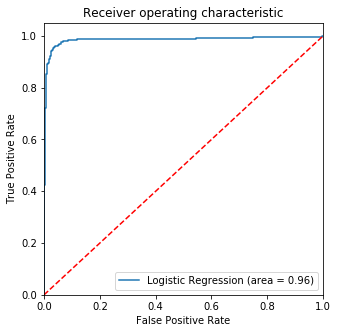

In [21]:
# Produce a ROC curve
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
logit_roc_auc = mt.roc_auc_score(y_test, lr_clf.predict(X_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_test, lr_clf.predict_proba(X_test_scaled)[:,1])
#logit_auc = mt.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Looking at the feature importance, we can see that total_incident_duration is an extremely strong predictor as is units_onscene. This further reinforces our belief that this might go beyond correlation and simply become a representation of the classification. We might explore leaving one or both of these values out of the model simply because they are too strong an indicator and represent the class itself. 

Text(0.5, 1.0, 'Feature importance')

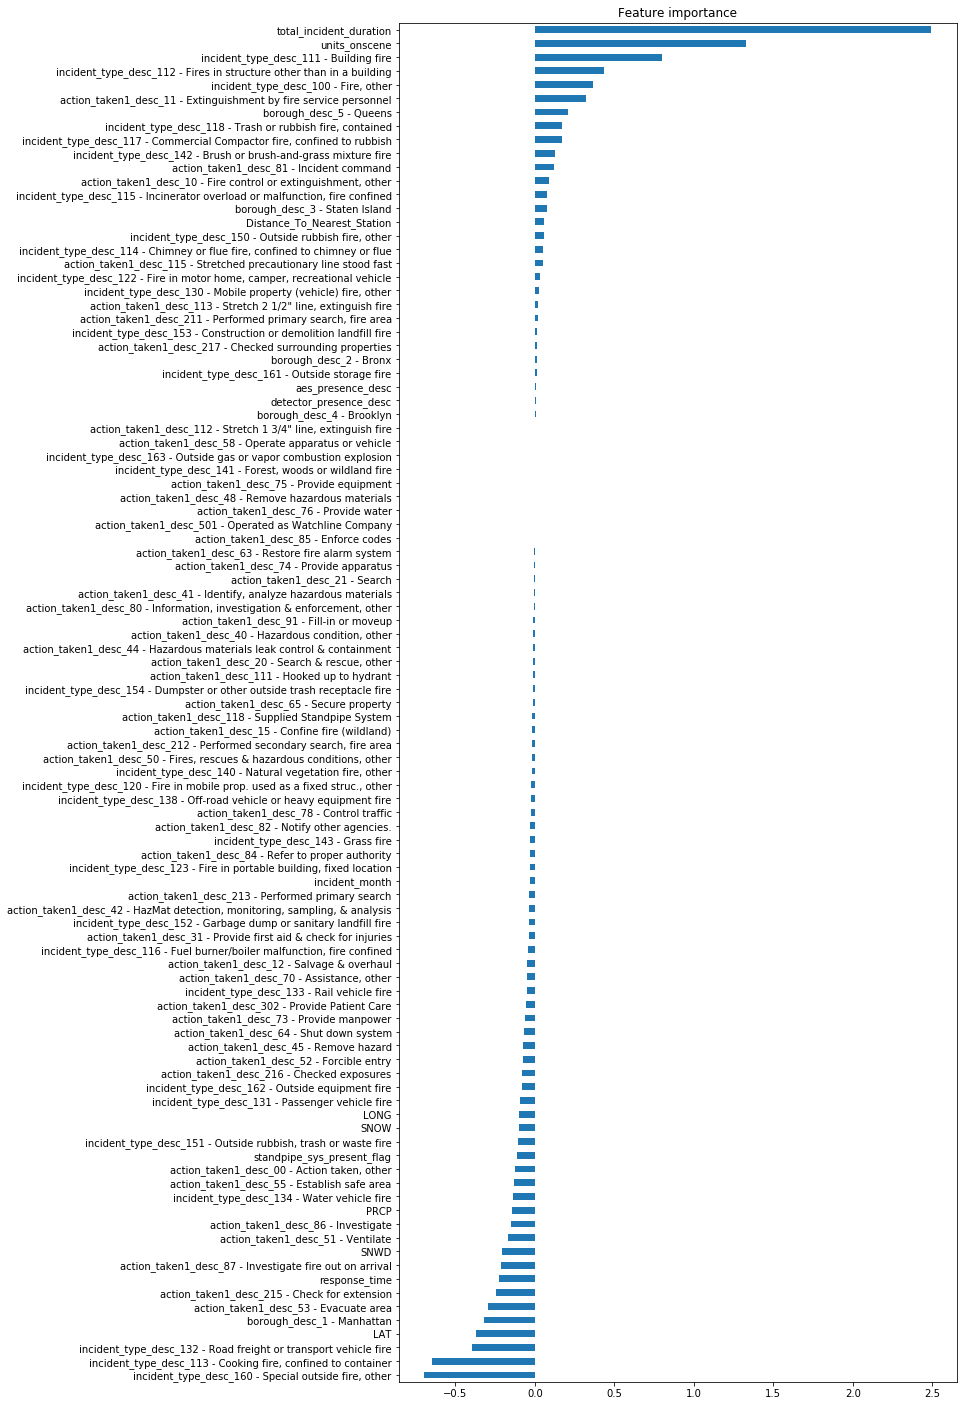

In [22]:
# Examine the feature importance by using the coefficients of the LR model. 
coef = pd.Series(lr_clf.coef_[0], index = X_train.columns)
# Sort the coefficients for easy interpretation
imp_coef = coef.sort_values()
# Expand the plot to display nicely. 
matplotlib.rcParams['figure.figsize'] = (10.0, 25.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance")

### Logistic Regression: Improving the Model

#### Leaving out two variables that essentially are the predicted value. 

We made the decision to leave out `units_onscene` and `total_incident_duration` as they were too directly linked to the outcome and offered no real business insight. It is obvious that more severe fires will last longer and that more units will respond to more severe fires. While this hampers the accuracy (and related metrics) overall, these were artificially inflated predictions with these two variables in place as they violate the independence assumption of the model. 



In [23]:
#Drop columns that violate the independence assumption. 
model_df = model_df.drop(columns = ['total_incident_duration', 'units_onscene'])

#Rebuild train / test set with dropped variables. 
X_train, X_test, y_train, y_test = train_test_split(model_df.iloc[:,0:97], model_df.iloc[:,97], test_size=0.20, random_state=42)

#Recreate the scaled data set with dropped variables. 

scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # applyto the test set

#### Grid Search for Model Improvement

After experimenting with a number of grid search parameters and feature reduction models, we settled on the following grid search using precision as the scoring metric. Note that we do use 5-fold cross validation as part of this effort. 

In [24]:
#Create a logistic regression pipeline to evaluate the various parameters
pipe = Pipeline([('classifier' , LogisticRegression())])


#Paramgrid for all the solver types and with cost functions adjusted for scaled vars
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' :  (0.001, 0.01, 0.05, 5),
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter' : (500,800,1000),
    'classifier__class_weight' :['balanced']}
]

# Create grid search object using precision as the metric
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, scoring = 'precision', n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train_scaled, y_train)

# Calculate the predictions
y_hat = best_clf.predict(X_test_scaled)

# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_test,y_hat)) 
print("precision", mt.precision_score(y_test,y_hat))
print("recall", mt.recall_score(y_test,y_hat))
print("confusion matrix\n",mt.confusion_matrix(y_test,y_hat))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.0min finished


accuracy 0.9521367521367521
precision 0.5369261477045908
recall 0.9307958477508651
confusion matrix
 [[4744  232]
 [  20  269]]


As discussed above, we can see that the numbers are generally lower than our baseline above due to the exclusion of the overly correlated values. That said, this does represent an improvement over intermediate models. 

In order to obtain and evaluate the coefficients, we'll need to re-fit the model using these newly identified parameters found in the grid search. 

In [25]:
#Display the best parameters identified by gridsearch
best_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=500, multi_class='warn',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='newton-cg',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [26]:
#Fit the model using these parameters. 
lr_clf = LogisticRegression(fit_intercept = True, intercept_scaling = 1, solver = 'newton-cg', max_iter = 500, penalty='l2', C=0.001, tol = 0.0001, class_weight='balanced')
lr_clf.fit(X_train_scaled,y_train)  # train object
y_hat = lr_clf.predict(X_test_scaled)

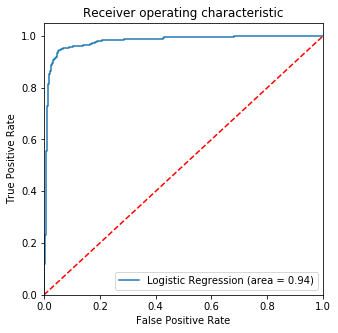

In [27]:
# Produce a ROC curve
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
logit_roc_auc = mt.roc_auc_score(y_test, lr_clf.predict(X_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_test, lr_clf.predict_proba(X_test_scaled)[:,1])
#logit_auc = mt.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Display the coefficients: 

In [28]:
# Sort the features by weight and display
zip_vars = zip(lr_clf.coef_.T,X_test.columns) 
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has scaled weight of', coef[0]) 


incident_type_desc_113 - Cooking fire, confined to container has scaled weight of -0.5883694008404716
incident_type_desc_151 - Outside rubbish, trash or waste fire has scaled weight of -0.2324560861854448
incident_type_desc_131 - Passenger vehicle fire has scaled weight of -0.15131149857291887
response_time has scaled weight of -0.1249239678730999
action_taken1_desc_86 - Investigate has scaled weight of -0.12266817262058367
action_taken1_desc_21 - Search has scaled weight of -0.09440521542675032
action_taken1_desc_53 - Evacuate area has scaled weight of -0.09194942612832352
action_taken1_desc_215 - Check for extension has scaled weight of -0.08504785542379946
LAT has scaled weight of -0.08442133429119786
incident_type_desc_116 - Fuel burner/boiler malfunction, fire confined has scaled weight of -0.07839070121779594
action_taken1_desc_87 - Investigate fire out on arrival has scaled weight of -0.07466192328862242
borough_desc_1 - Manhattan has scaled weight of -0.0687060991992958
SNWD ha

Text(0.5, 1.0, 'Feature importance')

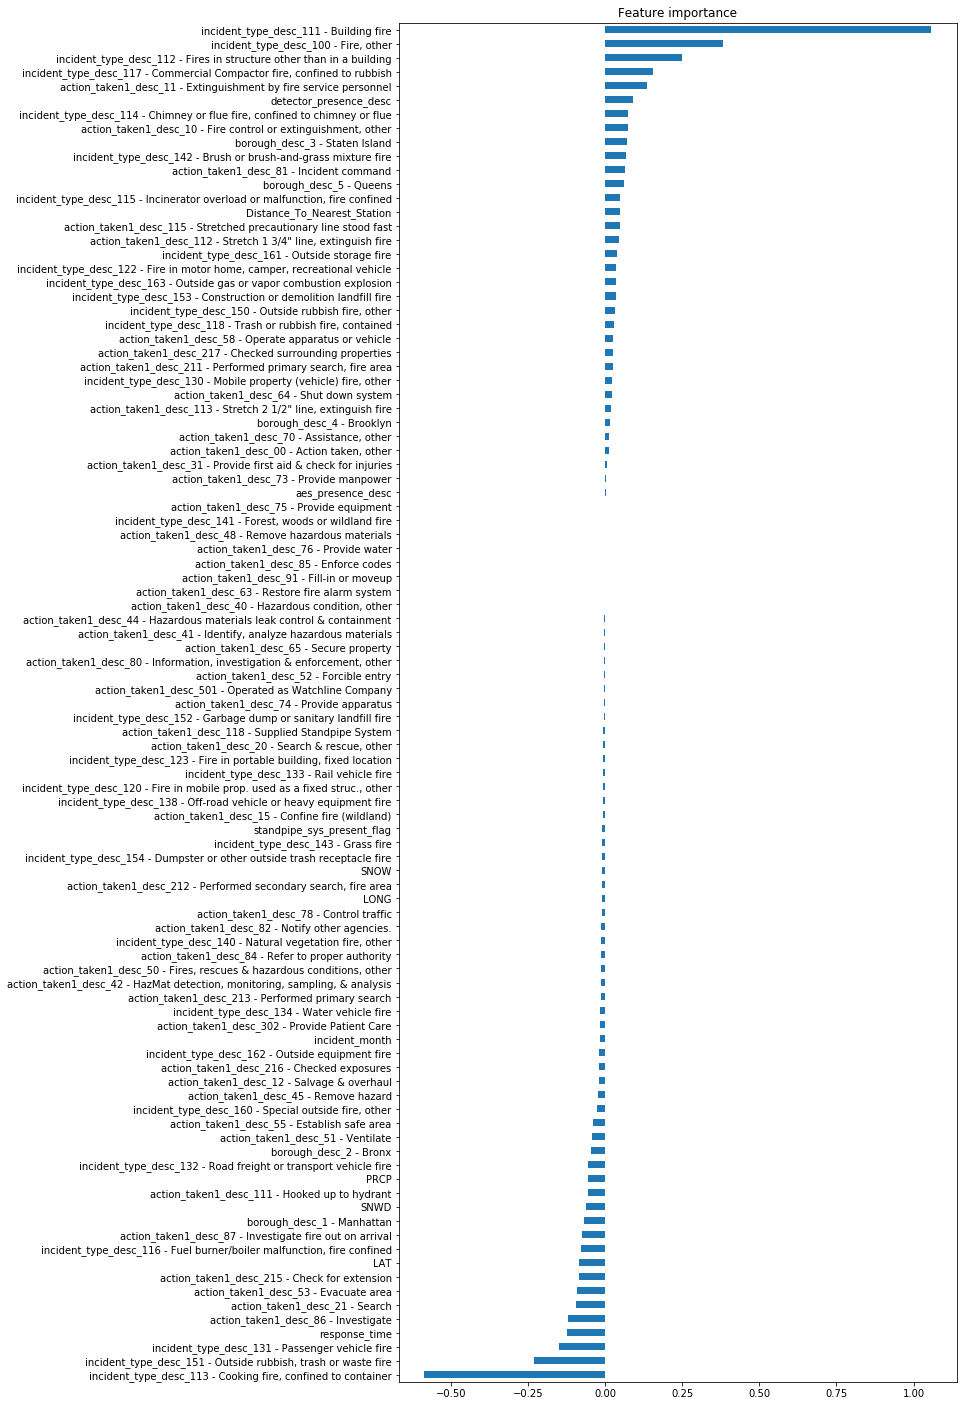

In [29]:
# Examine the feature importance by using the coefficients of the LR model. 
coef = pd.Series(lr_clf.coef_[0], index = X_train.columns)
# Sort the coefficients for easy interpretation
imp_coef = coef.sort_values()
# Expand the plot to display nicely. 
matplotlib.rcParams['figure.figsize'] = (10.0, 25.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance")

### Support Vector Machine: Baseline

Now that we've fitted the logistic regression model. We'll attempt to fit an SVM based model and evaluate its performance. We'll use the same train / test set and scaled features that we used for our optimized model above. 

In [30]:
# Create a new SVM model using the default parameters we used in class. Include probability to enable evaluation later. 
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto', probability = True)
# fit using the scaled data set
svm_clf.fit(X_train_scaled, y_train)

y_hat_svm = svm_clf.predict(X_test_scaled) # get test set predictions using scaled data

# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_test,y_hat_svm)) 
print("precision", mt.precision_score(y_test,y_hat_svm))
print("recall", mt.recall_score(y_test,y_hat_svm))
print("confusion matrix\n",mt.confusion_matrix(y_test,y_hat_svm))

accuracy 0.974738841405508
precision 0.7689655172413793
recall 0.7716262975778547
confusion matrix
 [[4909   67]
 [  66  223]]


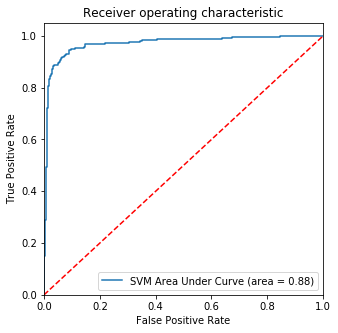

In [31]:
# Produce a ROC curve
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
svm_roc_auc = mt.roc_auc_score(y_test, svm_clf.predict(X_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_test, svm_clf.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Area Under Curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

Immediately we can see an increase in accuracy over the LR model and a drastic increase in precision performance. That said, the baseline model appears to have traded some recall to gain this improvement. This is reflected in the ROC curve where we can see a decrease in the ROC AUC to 0.88, but still solid performance. Let's move forward with the optimization of this through a gridsearch of various parameters. 

### Support Vector Machine: Improved Model

In [32]:
#Create a logistic regression pipeline to evaluate the various parameters
pipe = Pipeline([('classifier' , SVC())])


#Paramgrid for all the solver types and with cost functions adjusted for scaled vars
param_svm_grid = [
    {'classifier' : [SVC()],
    'classifier__C' :  (0.001, 0.01, 0.05),
    'classifier__gamma': (0.001, 0.01, 0.1, 1),
    'classifier__kernel' : ['linear','poly','rbf','sigmoid'],
    'classifier__class_weight' :['balanced']}
]

# Create grid search object using precision as the metric
svm_clf = GridSearchCV(pipe, param_grid = param_svm_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data
best_svm_clf = svm_clf.fit(X_train_scaled, y_train)

# Calculate the predictions
y_hat_svm = best_svm_clf.predict(X_test_scaled)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.1min
C:\Users\Brian\Anaconda3\envs\Python3_6\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 22.8min finished


In [33]:
print("accuracy", mt.accuracy_score(y_test,y_hat_svm)) 
print("precision", mt.precision_score(y_test,y_hat_svm))
print("recall", mt.recall_score(y_test,y_hat_svm))
print("confusion matrix\n",mt.confusion_matrix(y_test,y_hat_svm))

accuracy 0.9753086419753086
precision 0.7461300309597523
recall 0.8339100346020761
confusion matrix
 [[4894   82]
 [  48  241]]


In [34]:
best_svm_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=0.001, cache_size=200, class_weight='balanced',
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='sigmoid', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

With this optimization, we've traded some increased accuracy and recall for a slight decrease in precision. Still, this seems to exceed the performance of our logistic model holistically. Let's fit it using these parameters so we can create the same evaluation criteria.

In [35]:
#Fit SVM with the optimized parameters
svm_clf = SVC(C=0.001, cache_size=200, class_weight='balanced',
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='sigmoid', max_iter=-1,
                     random_state=None, shrinking=True,
                     tol=0.001, verbose=False, probability = True)
# fit using the scaled data set
svm_clf.fit(X_train_scaled, y_train)

y_hat_svm = svm_clf.predict(X_test_scaled)

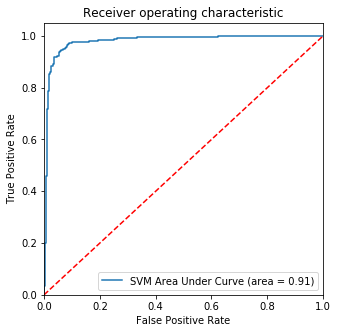

In [36]:
# Produce a ROC curve of this optimized model
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
svm_roc_auc = mt.roc_auc_score(y_test, svm_clf.predict(X_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_test, svm_clf.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Area Under Curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

We can see that in addition to improving our accuracy and recall metrics, the ROC AUC metric is also improved to 0.91. This model is the best balance of all the metrics that we obtained.

# Evaluation: 

### Discuss the advantages of each model for each classification task.

Practically logistic regression offers a highly interpretable model. The coefficients can be used to determine the log-odds ratio (and thereby level of relative risk) that any specific feature contributes to the outcome. It also does not require that values be scaled prior to training the model -- although this does help when evaluating the features against each other. 

Support Vector Machines lack interpretability in some cases, depending on the kernel selected, but also help to bring the ability to separate data that is not linearly seperable. 

### Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency?

In building the above models and looking at the results, the models performed in a generally comparable manner, particularly in the accuracy metric. We saw significant differences in the precision and recall between logistic regression. Specifically, logistic regression performed well in both accuracy and recall, but lacked in precision. SVM on the other hand increased accuracy and precision, but recall fell. Balancing these metrics is probably more a function of the business case and the real world impact to decision making. In our case, we prefer the more balanced metric outcomes provided by the SVM. 

Logistic regression models were generally faster to train, but in our data and analysis below, the Support Vector Machine generally provided better results. 

While individual model runs were not entirely problematic, when conducting grid searches for optimal model parameters the need to train repeated models accumulated significantly. The SVM models took much longer to optimize and for limited additional gain in the performance of the model -- which admittedly may be more about the characteristics of our data than the SVM itself. 



### Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

It is important to mention, again, the need to remove the `total_incident_duration` and `units_onscene variables` from the analysis due to the fact that they were essentially alternate encodings of the class we were attempting to predict. It is obvious to infer that the length of a fire incident and the number of responding units would indicate how severe that fire event is. 

Once we identified this correlation, however, we were able to generate some additional interesting insights that directly help to answer some of our original business case questions. Looking at the variable importance plot from the logistic regression above, we can see a series of trends emerging. 

**Building and structure fires are the most severe.** 

The greatest contributor to whether a fire is classified as severe or not is whether the incident type is reported as a building fire. In addition, fires in a structure other than a building is has high relative influence. Counterintuitively, the presence of a smoke detector is correlated with a more severe fire in the model, but this is likely due to the fact that detectors are primarily placed inside of structures -- which as we see are at greatest risk. 

**Contained fires, cooking fires in their original container, outdoor fires, or vehicle fires are generall not severe.**

Cooking fires contained to their container, outdoor rubbish or garbage fires, and vehicle fires are the strongest contributors to a fire being classified as not severe. This makes sense as their contained or isolated nature would likely make them more difficult to spread and become a more dynamic fire. 

**Geographic boroughs within the city do have an impact on fire severity.**

Fires occuring in Staten Island have the greatest risk of being classified as severe with Queens also being at significant risk. Conversely, Manhattan and the Bronx are more correlated with less severe fires. Being located in Brooklyn appeared neutral. 

This differentiation could be the result of fire department density in those areas or the types of structures present in either. Queens and Staten Island are more likely to have residential structures that may not be equipped with sprinkler systems or robust alarms. It might be worthwhile evaluating interaction terms between location and some of these other attributes in further modeling attempts. 

LATITUDE and LONGITUDE also contributed to the model in a manner generally consistent with this. Increased LATITUDE (or more Northern boroughs) were generally at less risk (Manhattan and the Bronx are the Northernmost boroughs). It makes sense that LONGITUDE's contribution is less because many of the boroughs share the same relative longitude. 

Increased distance to the nearest fire station also has some measurable contribution to increasing whether a fire will be classified as severe. Greater distance is a greater risk of severity and is likely an indication of the amount of time the fire has to develop. 

**Action taken may be more informative about future resource allocation**

The action taken category is probably not a strong predictor, but does offer insight into how resources are used in both severe and non-severe fires. Not surprisingly, during severe fires the action taken was highly correlated with extinguishing actions, establishment of control centers, and deployment of hoses in support of a precautionary effort. 

On the other hand, actions involved in non-severe fires included investigations, securing of the surrounding area, or finding the fire "out on arrival". Additional trend analysis on this data may offer some insight as to the level of unit that may need to be incorporated into the force or the training areas that teams need to focus on. 

**Increased precipitation is associated with less severe fires.**

Although it may seem obvious, the model confirms the fact that both rain precipiation and snow are associated with decreased fire severity. Interestingly, increased snow depth (SNWD in our model) indicating actually accumulated snow is a relatively strong indicator of decreased fire severity. Perhaps this is due to the ability of melting snow to aid in putting out fires. 

### Evaluating the Support Vectors

#### Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.
​
We were able to replicate the plots used in the example analysis provided by Dr. Larsen. Unfortunately, it appears that our plots do not show the same differentiation between the support vector density plots and the original data. This is, however, consistent with our assessment above that logistic regression is more easily interpreted than the support vectors. We do not really feel that these support vectors provide much meaningful insight into our data that we didn't more easily gain via the logistic regression analysis above. 

In [42]:
df_tested_on = X_train # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['FireLevel'] = y_train[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
X_train['FireLevel'] = y_train # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18695 entries, 11774 to 8325
Data columns (total 98 columns):
aes_presence_desc                                                              18695 non-null int64
detector_presence_desc                                                         18695 non-null int64
standpipe_sys_present_flag                                                     18695 non-null int64
response_time                                                                  18695 non-null float64
LONG                                                                           18695 non-null float64
LAT                                                                            18695 non-null float64
Distance_To_Nearest_Station                                                    18695 non-null float64
PRCP                                                                           18695 non-null float64
SNOW                                                                          

C:\Users\Brian\Anaconda3\envs\Python3_6\lib\site-packages\pandas\core\series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
C:\Users\Brian\Anaconda3\envs\Python3_6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


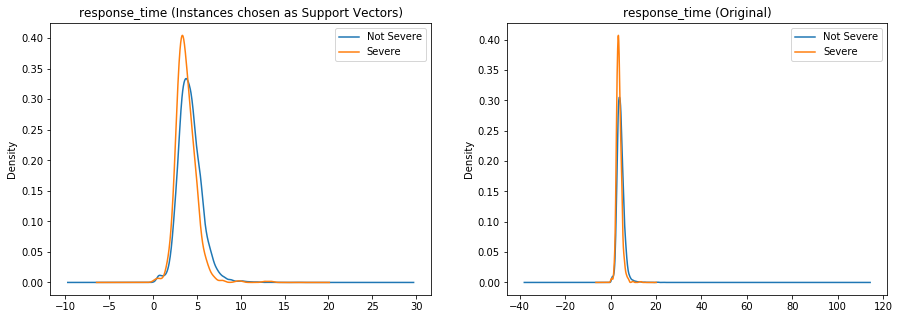

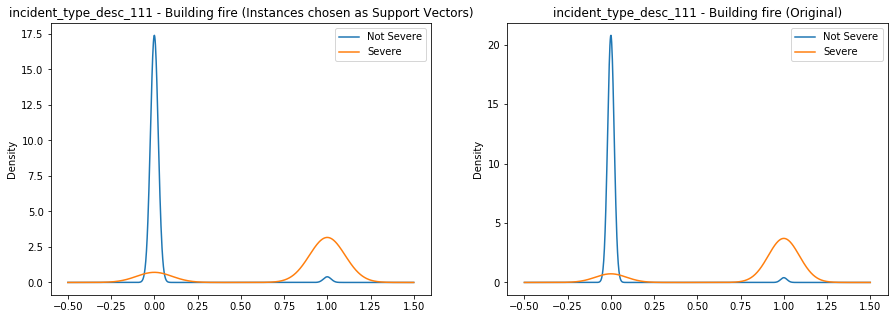

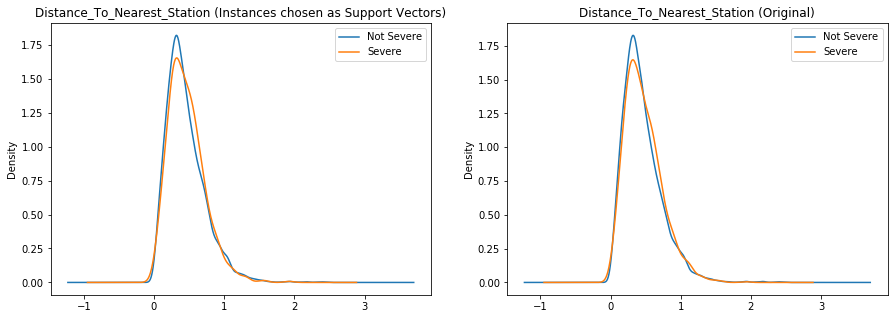

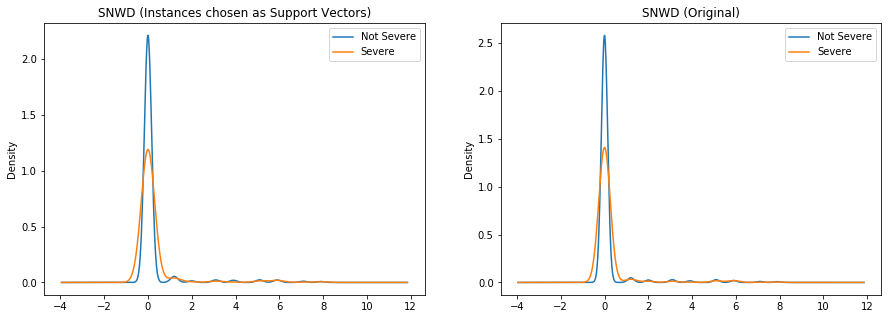

In [43]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['FireLevel'])
df_grouped = X_train.groupby(['FireLevel'])

# plot KDE of Different variables
vars_to_plot = ['response_time','incident_type_desc_111 - Building fire', 'Distance_To_Nearest_Station', 'SNWD']

for v in vars_to_plot:
    plt.figure(figsize=(15,5))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Severe','Severe'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Severe','Severe'])
    plt.title(v+' (Original)')

Looking at the distribution of the output of the SVM decision function on the training data, we can see both the imbalance in the data set and the ability of the function to discern between the two classes (Left of zero being out of class, Right of zero being in class). This appears to be as close as we can come to visualizing the Support Vectors. We can do the same on the test data. 

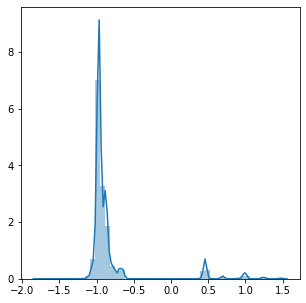

In [39]:
sns.distplot(svm_clf.decision_function(X_train_scaled))

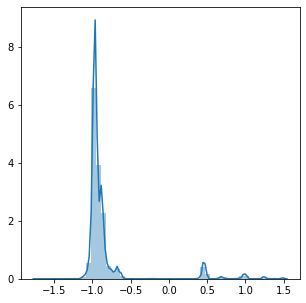

In [40]:
sns.distplot(svm_clf.decision_function(X_test_scaled))